## Darknet-like for CIFAR 10

The particular architecture we are going to look at is very close to the darknet architecture. 
But you will see in the process that the darknet architecture as in not the whole YOLO v3 end-to-end thing but just the part of it that they pre-trained on ImageNet to do classification. 
It’s a most generic simple architecture, so it is a great starting point for experiments. 
So we will call it “darknet” but it’s not quite that and you can fiddle around with it to create things that definitely aren’t darknet. 
It is the basis of nearly any modern ResNet based architecture.

In [1]:
import torch
torch.cuda.set_device(0)
torch.cuda.device_count()

2

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.conv_learner import *
PATH = Path("data/cifar10/")
os.makedirs(PATH,exist_ok=True)
torch.__version__

'0.4.0'

CIFAR10 is a small dataset [8:06], images are 32 by 32 in size.
It’s a great dataset to work with because:
- You can train it relatively quickly unlike ImageNet
- A relatively small amount of data
- Actually quite hard to recognize the images because 32 by 32 is too small to easily see what’s going on.

It is an under-appreciated dataset because it’s old. Who wants to work with small old dataset when they could use their entire server room to process something much bigger. But it’s is a really great dataset to focus on.

We need to compute the averages and standard deviations for each channel in CIFAR10, for `stats` below. 

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

trainset = dset.CIFAR10(root='data', train=True, download=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(trainset, batch_size=50_000, shuffle=True)
train = train_loader.__iter__().next()[0]

print('Mean: {}'.format(np.mean(train.numpy(), axis=(0, 2, 3))))
# Mean: [ 0.49139765  0.48215759  0.44653141]
print('STD: {}'.format(np.std(train.numpy(), axis=(0, 2, 3))))
# STD: [ 0.24703199  0.24348481  0.26158789]

cifarmeans = np.mean(train.numpy(), axis=(0, 2, 3))
cifarstds = np.std(train.numpy(), axis=(0, 2, 3))
stats = (cifarmeans, cifarstds)

Mean: [0.4914  0.48216 0.44653]
STD: [0.24703 0.24348 0.26159]


In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

Because these are fairly small, we can use a larger batch size than usual and the size of these images is 32

In [6]:
num_workers = num_cpus()//2
bs=256
sz=32

Normally we would use side_on transformations, but not for CIFAR, because the images are small.
Trying to rotate a 32 by 32 image would introduce a lot of blocky distortions. 
So we just use a random horizontal flip and then add 4 pixels ($size \div 8$) of padding on each side. 
Most libraries by default add black padding.
Fastai uses reflection padding by default: takes the last 4 pixels, flip it and reflect it, and get much better results.
Now we have 40 by 40 images, this set of transforms in training will randomly pick 32 by 32 crops, 
so we get a little bit of variation.

In [7]:
tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

### Architecture

Now an architecture [11:07] from scratch, using predefined Conv2d, BatchNorm2d, LeakyReLU modules,
but not using any blocks. 
So the entire modern, good quality architecture can be reviewed in one screen. <br>
The architecture is made of stacked layers with some "hierarchy" of layers [11:51]. 
At the very bottom, there are convolutional layer and a batch norm layer.
Whenever there is a convolution, there will be some standard sequence, normally:
1. conv
2. batch norm
3. a nonlinear activation (e.g. ReLU)

We start by defining a basic unit function (`conv_layer`).
This will keep everything consistent and simpler.

**NB** We don’t use PyTorch module in `conv_layer`, just `nn.Sequential` [14:07]. 
This is underutilized! 
Most people tend to write everything as a PyTorch module with __init__ and forward.
But if what we need is just a sequence, it’s much better (concise and easy to understand) to make it a Sequential.
Notice also the use of `LeakyReLU`, which is more useful on smaller datasets.

In [8]:
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))

The next level in the unit hierarchy for ResNet is the ResBlock or residual block (`ResLayer`). 
When we last did CIFAR10, we oversimplified. 
We had $x$ coming in and put it through a conv, then we added it back up to $x$ to go out. 
In the real ResBlock, there are 2, here `conv1` and `conv2`.
We use “conv” as a shortcut for our conv_layer (conv, batch norm, ReLU).

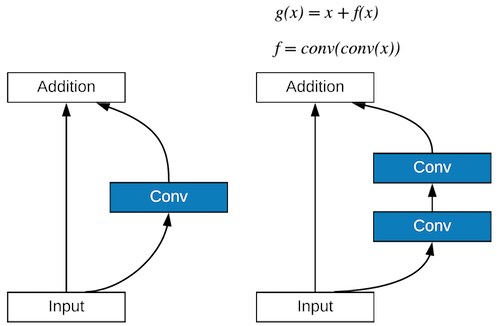

**NB: the number of channels** in these convolutions [16:47]. 
We have `ni` coming in (some number of input channels/filters). 
The darknet team made every one of the Res layers spit out the same number of channels that came in.
This makes life simpler.
`conv` halves the number of channels (`ni//2`), and `conv2` doubles it again. 
This is a funneling effect, eg 64 channels coming in, squished down by conv1 to 32 channels, 
and then taken up again to 64 channels coming out by `conv2`.
This funneling effect may not be a good idea, per "wide Resnet" paper.

In [9]:
class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1=conv_layer(ni, ni//2, ks=1)
        self.conv2=conv_layer(ni//2, ni, ks=3)
        
    def forward(self, x): return x.add_(self.conv2(self.conv1(x)))

`Darknet.make_group_layer` contains a bunch of ResLayer [31:28]. 
`group_layer` is going to have some number of channels/filters coming in. 
We double the number of channels coming in by just using the standard conv_layer. 
Optionally, we will halve the grid size by using a stride of 2. 
Then we are going to do a bunch of ResLayers — we can pick how many (2, 3, 8, etc),
because ResLayers do not change the grid size, they don’t change the number of channels. 
So we can add any number, but, the more ResLayers, the more computation and RAM required.  
`group_layer`, will double the number of channels, because the initial convolution doubles the number of channels.
Depending on what we pass in `stride`, it may also halve the grid size (eg if `stride=2`). 
Then we can do as many Res blocks as we like.

In [10]:
class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks, num_classes, nf=32):
        super().__init__()
        layers = [conv_layer(3, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, num_classes)]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x): return self.layers(x)

Sequential [35:53]: 
A nice way to create architectures is to start out by creating a list.
Here this is a list with just one conv_layer in, and make_group_layer returns another list. 
Then we can append that list to the previous list with += and do the same for another list containing AdaptiveAvnPool2d. 
```
layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, num_classes)]
```
Finally we will call nn.Sequential of all those layers. 
Now the forward is just self.layers(x).

This is a good way to make your architectures as simple as possible. 
There are a lot you can fiddle with, for example: 
- parameterize the divider of `ni` -   maybe do times 2 instead. 
- change the kernel size
- change the number of convolutional layers. 

JH has a version which implements all the different parameters in the Wide ResNet paper, to see what worked well.

To define our Darknet, we are going to pass in something that looks like this [33:13]:

In [11]:
m = Darknet([1, 2, 4, 6, 3], num_classes=10, nf=32)
#m = nn.DataParallel(m, [1,2,3])   # only 1 GPU, 0 here...

`Darknet([1, 2, 4, 6, 3], num_classes=10, nf=32)` 
means create 5 group layers: 
first one will contain 1 extra ResLayer, the second will contain 2, then 4, 6, 3.
And we want to start with 32 filters. 
The first one of ResLayers will contain 32 filters, and there will just be one extra ResLayer. 
The second one, it’s going to double the number of filters because that’s what we do each time we have a new group layer. 
So the second one will have 64, and then 128, 256, 512 and that’ll be it. 
Nearly all of the network is going to be those bunches of layers.
Every one of those group layers also has one convolution at the start. 
Before that, we are going to have one convolutional layer at the very start, 
and at the very end we do our standard adaptive average pooling, flatten, 
and a linear layer to create the number of classes out at the end. 

To summarize [34:44], one convolution at one end, adaptive pooling and one linear layer at the other end, 
and in the middle, these group layers each one consisting of a convolutional layer followed by n number of ResLayers.

In [12]:
#m = Darknet([1, 2], num_classes=10, nf=32)


In [13]:
lr = 1.3

Now we use `ConvLearner.from_model_data` to take our PyTorch module and a model data object, and turn them into a learner [37:08]. 
Give it a criterion, optionally add a metrics, and then fit. 

In [14]:
learn = ConvLearner.from_model_data(m, data)
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4

In [15]:
%pdb

Automatic pdb calling has been turned ON


In [ ]:
%time learn.fit(lr, 1, wds=wd, cycle_len=30) #, use_clr_beta=(20, 20, 0.95, 0.85))

  0%|          | 0/196 [00:00<?, ?it/s]


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation

> /home/german/anaconda3/envs/GSGfastai/lib/python3.6/site-packages/torch/autograd/__init__.py(89)backward()
     87     Variable._execution_engine.run_backward(
     88         tensors, grad_tensors, retain_graph, create_graph,
---> 89         allow_unreachable=True)  # allow_unreachable flag
     90 
     91 

ipdb> p tensors
(tensor(2.3261, device='cuda:0'),)
ipdb> p grad_tensors
(tensor(1., device='cuda:0'),)
ipdb> retain_graph
False
ipdb> create_grap
*** NameError: name 'create_grap' is not defined
ipdb> create_graph
False


In [ ]:
# DP: m = WideResNet(depth=22, num_classes=10, widen_factor=6, dropRate=0.)
learn.fit(lr/10, 1, wds=wd, cycle_len=1, use_clr_beta=(100, 1, 0.9, 0.8))

In [ ]:
%time learn.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(20, 20, 0.95, 0.85))

In [ ]:
learn.fit(lr/10, 1, wds=wd, cycle_len=1, use_clr_beta=(100, 1, 0.9, 0.8))

In [ ]:
%time learn.fit(lr, 1, wds=wd, cycle_len=40, use_clr_beta=(10, 15, 0.95, 0.85))

In [ ]:
learn.fit(lr/10, 1, wds=wd, cycle_len=1, use_clr_beta=(100, 1, 0.9, 0.8))

In [ ]:
%time learn.fit(1., 1, wds=wd, cycle_len=30, use_clr_beta=(10, 25, 0.95, 0.85))

In [ ]:
%time learn.fit(lr, 1, wds=wd, cycle_len=40, use_clr_beta=(100, 15, 0.95, 0.85))

In [ ]:
# darknet 2222 lr 1.3 65 cl
%time learn.fit(lr, 1, wds=wd, cycle_len=65, use_clr_beta=(30, 20, 0.95, 0.85))